In [5]:
# !git clone https://github.com/tordjx/ummt.git
# import os 
# os.chdir("ummt/Core model files")
# os.getcwd()
!pip install matplotlib --quiet
!pip install livelossplot --quiet
!pip install nltk --quiet
!pip install torchtext --quiet
#mc cp s3/tordjx ummt/Core*model*files --recursive
# watch -n 0.5 nvidia-smi
import nltk
nltk.download('wordnet')
image_bool = True
load_model = True

[nltk_data] Downloading package wordnet to /home/onyxia/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [6]:
#%%
from Modele_decodeur_maison import *
from Pipeline import *
from Trainer import * 
from greedy_beam_search import *

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256

# Texts
tokenized_fr,tokenized_en, vocab_fr,vocab_en = get_train_data_nouveau(batch_size,True)
tokenized_val_fr,tokenized_val_en, _,_ = get_train_data_nouveau(batch_size,False)
#Data non batchés
n_token_fr = len(vocab_fr.keys())
n_token_en = len(vocab_en.keys())

inv_map_en = {v: k for k, v in vocab_en.items()}
inv_map_fr = {v: k for k, v in vocab_fr.items()}

n_head =8
num_encoder_layers = 4
num_decoder_layers = 4
dim_feedforward = 512
dropout = 0.1
activation = nn.Softmax(dim=2)
embedding_dim = 128
prefix = "fulltry_IMG"
model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],False,prefix).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],False,prefix).to(device)
model_fr.feedforward= model_en.feedforward
for i in range(3):
  model_fr.decoder.layers[i]= model_en.decoder.layers[i]
  model_fr.encoder.layers[i]= model_en.encoder.layers[i]

if load_model : 
    model_en.load_state_dict(torch.load("tordjx/"+prefix+"_en"))
    model_fr.load_state_dict(torch.load("tordjx/"+prefix+"_fr"))
else : 
    with open(prefix+"logs.txt",'w') as logs :
        logs.write("")
        logs.close()
if image_bool :
    train_features  = np.load("tordjx/train-resnet50-res4frelu.npy")
    val_features = np.load("tordjx/val-resnet50-res4frelu.npy")
    train_features = torch.from_numpy(train_features)
    val_features = torch.from_numpy(val_features)
    train_data_fr = [tokenized_fr, train_features]
    train_data_en = [tokenized_en, train_features]
    val_data_fr = [tokenized_val_fr, val_features]
    val_data_en = [tokenized_val_en, val_features]
def save_model(model_en,model_fr,prefix):
    torch.save(model_fr.state_dict(), "tordjx/"+prefix+"_fr")
    torch.save(model_en.state_dict(), "tordjx/"+prefix+"_en")
    import os
    import s3fs
    !pip install pandas
    import pandas
    # Create filesystem object
    S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
    fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})
    fs.upload("tordjx/"+prefix+"_fr","tordjx/"+prefix+"_fr")
    fs.upload("tordjx/"+prefix+"_en","tordjx/"+prefix+"_en")
    fs.upload(prefix+"logs.txt",prefix+"logs.txt")

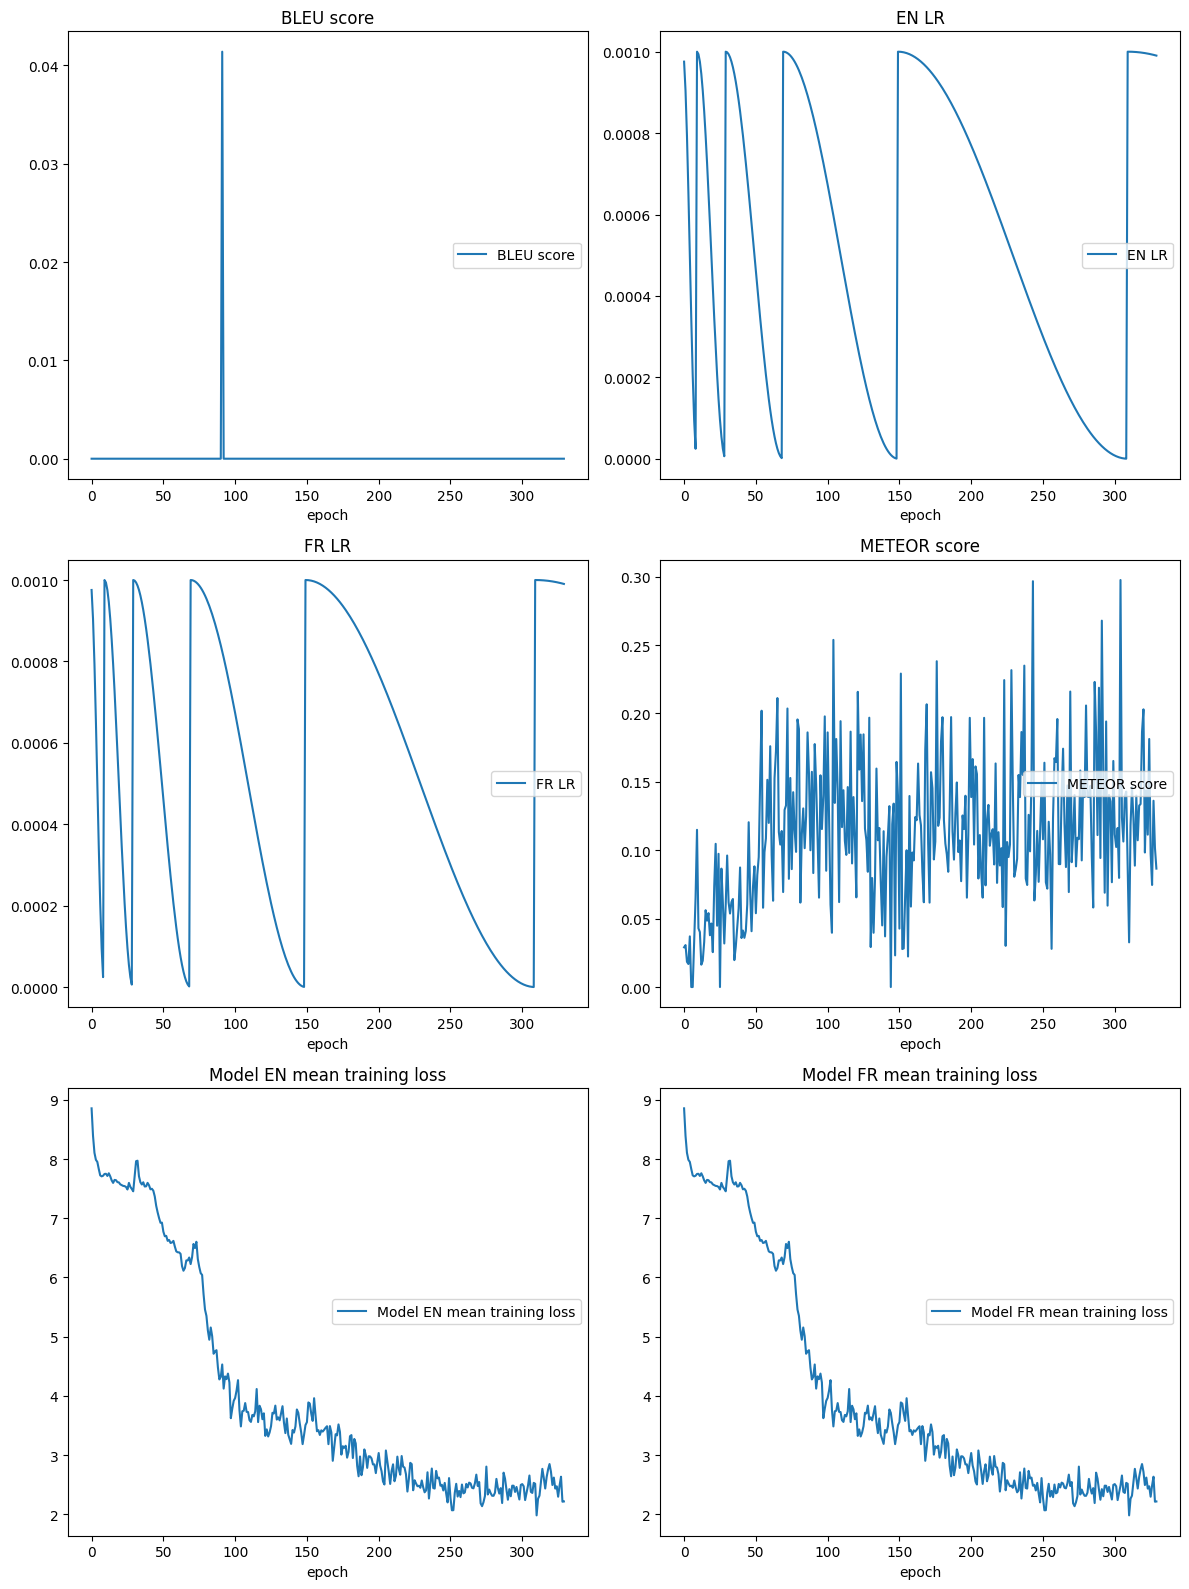

BLEU score
	BLEU score       	 (min:    0.000, max:    0.041, cur:    0.000)
EN LR
	EN LR            	 (min:    0.000, max:    0.001, cur:    0.001)
FR LR
	FR LR            	 (min:    0.000, max:    0.001, cur:    0.001)
METEOR score
	METEOR score     	 (min:    0.000, max:    0.298, cur:    0.087)
Model EN mean training loss
	Model EN mean training loss 	 (min:    1.984, max:    8.856, cur:    2.219)
Model FR mean training loss
	Model FR mean training loss 	 (min:    1.984, max:    8.856, cur:    2.219)


ValueError: Attempt to open non key-like path: fulltrylogs.txt

In [4]:
teacher_forcing =False
model_fr = Modèle(n_token_fr,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_fr["TOKEN_VIDE"],vocab_fr["DEBUT_DE_PHRASE"],vocab_fr["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
model_en = Modèle(n_token_en,embedding_dim,n_head, num_encoder_layers,num_decoder_layers,dim_feedforward,dropout,activation,vocab_en["TOKEN_VIDE"],vocab_en["DEBUT_DE_PHRASE"],vocab_en["FIN_DE_PHRASE"],teacher_forcing,prefix).to(device)
model_fr.feedforward= model_en.feedforward
for i in range(3):
    model_fr.decoder.layers[i]= model_en.decoder.layers[i]
    model_fr.encoder.layers[i]= model_en.encoder.layers[i]
with open(prefix+"logs.txt",'w') as logs :
    logs.write("")
    logs.close()
nepochs = 60
if image_bool :
    mixed_train(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,nepochs,batch_size, True,1/2)
else :
    mixed_train(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,nepochs,batch_size, False,1/2)
save_model(model_en,model_fr,prefix)

In [7]:
#Copilot generated code
from torchvision import models, transforms
from PIL import Image
import requests
def relu_layer(x):
    return torch.nn.functional.relu(x)

def open_image(path):
    image = Image.open(path)
    image = image.resize((224, 224))
    image = transforms.ToTensor()(image)
    image = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])(image)
    return image

def get_resnet_features_from_image(image):
    resnet = models.resnet152(pretrained=True)
    resnet.eval()
    resnet = resnet.to(device)
    resnet = nn.Sequential(*list(resnet.children())[:-1])
    image = image.to(device)
    image = image.unsqueeze(0)
    image = resnet(image)
    image = image.squeeze(0)
    return image


import torchtext
import pandas as pd
def dataframe_eval(model_fr,model_en,val_data_en,val_data_fr,inv_map_en,inv_map_fr,image_bool) :
    model_fr.eval()
    model_en.eval()
    if image_bool :
        val_data_en,features= tokenized_val_en
        val_data_fr,features= tokenized_val_fr
    else :
        val_data_en,val_data_fr = val_data_en,val_data_fr
    batched_data_en,batched_data_fr=batchify([val_data_en,val_data_fr],batch_size,image_bool,conservative=True,permute = False)
    if image_bool:
        src,features = batched_data_en
        tgt,_ = batched_data_fr
    else :
        src,tgt = batched_data_en,batched_data_fr
    traductions_en_fr = []
    references_en = []
    traductions_fr_en = []
    references_fr = []
    for batch in range(len(src)):
        print(batch)
        if image_bool :
            src[batch],features[batch],tgt[batch] = src[batch].to(device),features[batch].to(device),tgt[batch].to(device)
            traduction = torch.argmax(CCF_greedy(model_en,model_fr,src[batch],features[batch],image_bool) ,dim = 2)
        else :
            src[batch] ,tgt[batch]= src[batch].to(device),tgt[batch].to(device)
            traduction = torch.argmax(CCF_greedy(model_en,model_fr,src[batch],None,image_bool) ,dim = 2)
        
        for i in range(traduction.shape[0]):
            traductions_en_fr.append([inv_map_fr[traduction[i][j].item()]  for j in range(traduction.shape[1]) if inv_map_fr[traduction[i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])
            references_fr.append([inv_map_fr[tgt[batch][i][j].item()] for j in range(tgt[batch].shape[1]) if inv_map_fr[tgt[batch][i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])
        if image_bool :
            traduction = torch.argmax(CCF_greedy(model_fr,model_en,tgt[batch],features[batch],image_bool) ,dim = 2)
        else :
            traduction = torch.argmax(CCF_greedy(model_fr,model_en,tgt[batch],None,image_bool) ,dim = 2)
        for i in range(traduction.shape[0]):
            traductions_fr_en.append([inv_map_en[traduction[i][j].item()]  for j in range(traduction.shape[1]) if inv_map_en[traduction[i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])
            references_en.append([inv_map_en[src[batch][i][j].item()] for j in range(src[batch].shape[1]) if inv_map_en[src[batch][i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])
        if image_bool: #Si image, on rajoute les traductions sans images
            traductions_en_fr_txt_only = []
            traductions_fr_en_txt_only = []
            src[batch],tgt[batch] = src[batch].to(device),tgt[batch].to(device)
            traduction = torch.argmax(CCF_greedy(model_en,model_fr,src[batch],None,False) ,dim = 2)
            for i in range(traduction.shape[0]):
                traductions_en_fr_txt_only.append([inv_map_fr[traduction[i][j].item()]  for j in range(traduction.shape[1]) if inv_map_fr[traduction[i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])
                references_fr.append([inv_map_fr[tgt[batch][i][j].item()] for j in range(tgt[batch].shape[1]) if inv_map_fr[tgt[batch][i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])
            traduction = torch.argmax(CCF_greedy(model_fr,model_en,tgt[batch],None,False) ,dim = 2)
            for i in range(traduction.shape[0]):
                traductions_fr_en_txt_only.append([inv_map_en[traduction[i][j].item()]  for j in range(traduction.shape[1]) if inv_map_en[traduction[i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])
                references_en.append([inv_map_en[src[batch][i][j].item()] for j in range(src[batch].shape[1]) if inv_map_en[src[batch][i][j].item()] not in ["TOKEN_VIDE","DEBUT_DE_PHRASE","FIN_DE_PHRASE"]])
            
    if image_bool:
        data = {"traductions_en_fr":traductions_en_fr,"references_fr":references_fr,"traductions_fr_en":traductions_fr_en,"references_en":references_en,"traductions_en_fr_txt_only":traductions_en_fr_txt_only,"traductions_fr_en_txt_only":traductions_fr_en_txt_only}
    else :
        data = {"traductions_en_fr":traductions_en_fr,"references_fr":references_fr,"traductions_fr_en":traductions_fr_en,"references_en":references_en}
    
    df = pd.DataFrame(data)
    def bleu(row,langue_src):
        if langue_src == "en":
            return torchtext.data.metrics.bleu_score([list(row["traductions_en_fr"])], [[list(row["references_fr"])]])
        else : 
            return torchtext.data.metrics.bleu_score([list(row["traductions_fr_en"])], [[list(row["references_en"])]])
    def bleu_txt_only(row,langue_src):
        if langue_src == "en":
            return torchtext.data.metrics.bleu_score([list(row["traductions_en_fr_txt_only"])], [[list(row["references_fr"])]])
        else : 
            return torchtext.data.metrics.bleu_score([list(row["traductions_fr_en_txt_only"])], [[list(row["references_en"])]])
    df["bleu_en_fr"] = df.apply(lambda row: bleu(row,"en"), axis=1)
    df["bleu_fr_en"] = df.apply(lambda row: bleu(row,"fr"), axis=1)
    if image_bool:
        df["bleu_en_fr_txt_only"] = df.apply(lambda row: bleu_txt_only(row,"en"), axis=1)
        df["bleu_fr_en_txt_only"] = df.apply(lambda row: bleu_txt_only(row,"fr"), axis=1)
    return df.loc()[:tokenized_val_fr.shape[0]-1]
    
df = dataframe_eval(model_fr,model_en,tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,image_bool)
df.to_csv(model_fr.prefix+"_eval.csv")

0


/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched src_key_padding_mask and src_mask is deprecated. Use same type for both instead.
  warnings.warn(
/opt/mamba/lib/python3.10/site-packages/torch/nn/functional.py:4999: UserWarning: Support for mismatched key_padding_mask and attn_mask is deprecated. Use same type for both instead.
  warnings.warn(


1
2
3


In [ ]:
# if image_bool :
#     loss_list = learning_rate_finder(val_data_en,val_data_fr,inv_map_en,inv_map_fr,model_fr,model_en,train_data_fr,train_data_en,150,batch_size, True,1/2)
# else :
#     loss_list = learning_rate_finder(tokenized_val_en,tokenized_val_fr,inv_map_en,inv_map_fr,model_fr,model_en,tokenized_fr,tokenized_en,150,batch_size, False,1/2)

lrs = [10**(-10)*3**n for n in range(len(loss_list))]
cut = 11
begin = 10
plt.plot(lrs[begin:-cut],loss_list[begin:-cut])
plt.xscale('log')
plt.show()

In [ ]:
def moving_average(a, n=1,tail = 0) :
    ret = np.cumsum(a, dtype=float)
    ret[n:] = ret[n:] - ret[:-n]
    
    return (ret[n - 1:] / n)[tail:]

plt.plot(moving_average(model_fr.loss_list))
plt.plot(moving_average(model_en.loss_list))
print(len(model_fr.loss_list)/(29000/batch_size))


In [ ]:
tokenized_val_en = val_data_en[0]
i = np.random.randint(len(tokenized_val_en)//batch_size)
j = np.random.randint(batch_size)
src,features,tgt = donne_random(i,j,val_data_en,val_data_fr,batch_size,True)
features = features.to(device,dtype=torch.float32)
data = [src,features]
# OUT= traduit('greedy',model_en,model_fr,data, inv_map_en,True,tgt[j],inv_map_fr,j)
OUT = greedy_beam_search.CCF_greedy(model_en,model_fr,src, features, True)
values,indices = torch.topk(OUT,2,2)
print(values)
print(indices)